## Biodiversity Intactness Index change in Phoenix, AZ
Mapping fires with true color and false color imagery and visualizing its impacts socioeconomically. 
 
### Author: Isabella Segarra 
[Link to Github repository](https://github.com/IsabellaSegarra/eds220-hwk4)

### Objective:


### About the data:
#### Biodiversity Intactness Index (BII) Time Series  
This data is accessed through the Microsoft Planetary Computer.

#### Phoenix Subdivision Shapefile


### Analysis:
1.




**Import the necessary packages**

In [1]:
# Environment set-up 
import pandas as pd # for data wrangling
import numpy as np  # for data wrangling 

import geopandas as gpd # for geospatial data 
import os # for data import

import matplotlib.pyplot as plt  # for visualizations 
import contextily as cx 

import xarray as xr # for Netcdf4 data 
import rioxarray as rio # for raster data 

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from shapely.geometry import box

## Data import and exploration

### Biodiversity Intactness Index (BII) Time Series 
In this step I will acess the `io-biodiversity` catalog from the *Microsoft Planetary Computer*.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

catalog.get_collections() # Access collections
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the io-biodiversity collection
io_biodiversity = catalog.get_child('io-biodiversity')
io_biodiversity

Number of collections: 126


<CollectionClient id=io-biodiversity>

Explain here about what you learn from above.

In [3]:
# Explore catalog metadata 
print('Title:', io_biodiversity.title)
print('Description: ', io_biodiversity.description)

Title: Biodiversity Intactness
Description:  Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between observed biodiversity m

Further refine the `io-biodiversiry` to 2017 and 2020 rasters and with the following coordinates to match the Pheonix, AZ region.

[-112.826843, 32.974108, -111.184387, 33.863574]

In [4]:
# time range of study
time_range = "2017-01-01/2020-12-31"

In [5]:
# bbox 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Create a catalog search within the `io-biodiversity` collection to the bbox and time range specified earlier.

In [6]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox, 
    datetime = time_range)

# Get items from search
items = search.item_collection()

# Determine number of items in search
len(items)

4

This catalog now contains the time range 2017-2020, including the years in between. In this next section I searched the items to see which feature corresponds to the years I want: 2017 and 2020.

In [7]:
# find the years from the items
items

Index to the years I want from the `items`.

In [8]:
# pull 2017 and 2020 years from 
item_2020 = items[0] # 0 = 2020
item_2017 = items[3] # 3 = 2017

Open `item_2020` and `item_2017` as raster objects with `rio.open_rasterio`.

In [9]:
bio_2020 = rio.open_rasterio(item_2020.assets['data'].href)
bio_2017 = rio.open_rasterio(item_2017.assets['data'].href)

## Arizona TIGER shapefile
In this section I will import the Arizona shapefile in order to utilize its boundary for plotting and clipping the rasters.

In [10]:
# Import data
arizona = gpd.read_file(os.path.join('data', 
                                    'tl_2023_04_cousub', 
                                    'tl_2023_04_cousub.shp'))

Exploration of Arizona shapefile. 

In [11]:
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231050070,44656143,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


<Axes: >

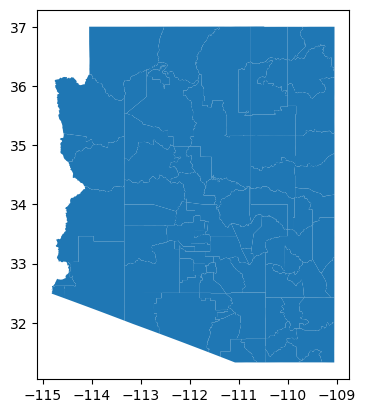

In [12]:
arizona.plot()

### Filter to Phoenix Subdivision
In this section I will filter the `arizona` gpd to the Phoenix region.

In [13]:
phoenix_az = arizona[arizona['NAME'] == 'Phoenix']

<Axes: >

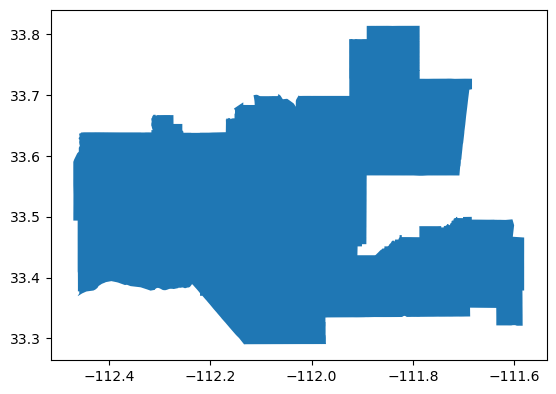

In [14]:
phoenix_az.plot()

In [15]:
print('CRS: ', phoenix_az.crs)

CRS:  EPSG:4269


In [16]:
# Find CRS 
print('CRS: ', bio_2017.rio.crs)

CRS:  EPSG:4326


In order to plot the Phoenix subdivision I need to match the CRS of `phoenix_az` to the biodiversity rasters (`bio_2017` and `bio_2020`).

In [17]:
# Assert that both rasters have matching CRSs
assert bio_2017.rio.crs == bio_2020.rio.crs 

In [18]:
#Match CRS of Phoenix to bio_2017 raster 
phoenix_az = phoenix_az.to_crs(crs = bio_2017.rio.crs)

In [19]:
# Assert that CRS matches now
assert phoenix_az.crs == bio_2017.rio.crs

## Map 1: Pheonix Subdivision 

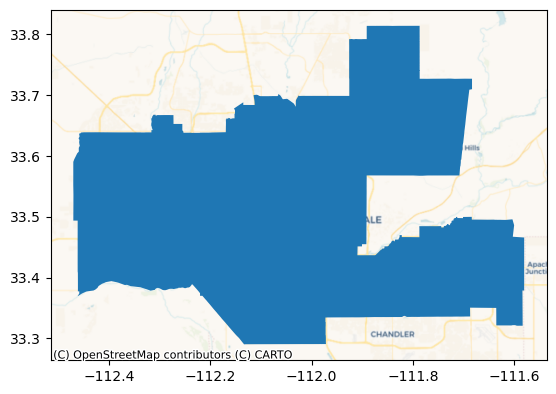

In [20]:
ax = phoenix_az.plot()
cx.add_basemap(ax, crs = bio_2020.rio.crs, source = cx.providers.CartoDB.Voyager)

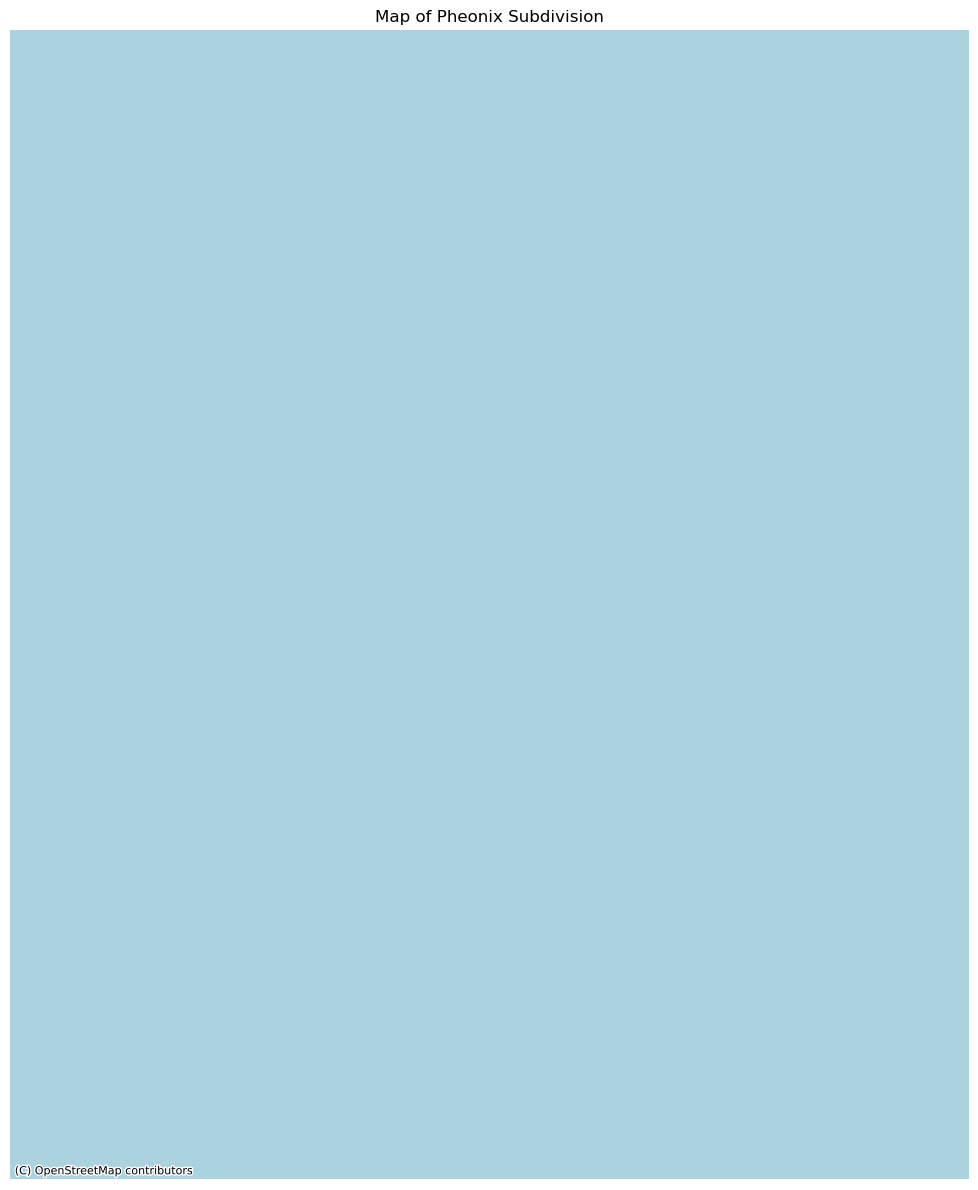

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Add basemap using contextily
cx.add_basemap(ax, crs= bio_2017.rio.crs, source=cx.providers.OpenStreetMap.Mapnik)

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR
phoenix_az.plot(ax = ax, color = 'grey', edgecolor = 'black', alpha = 0.5, label = 'Pheonix') 

# ADD TITLE
ax.set_title("Map of Pheonix Subdivision", fontsize=12)
ax.axis('off')

plt.tight_layout()
plt.show()

## Map 2: BII in Pheonix, AZ

### Clip Rasters to Phoenix Subdivision
In this section, clipped the `bio_2017` and `bio_2020` rasters to the `pheonix_az` geometries with `rio.clip`.

In [ ]:

bio_2017 = bio_2017.rio.clip(phoenix_az.geometry) #maybe add crs 
bio_2020 = bio_2020.rio.clip(phoenix_az.geometry)            


View the clipped rasters.

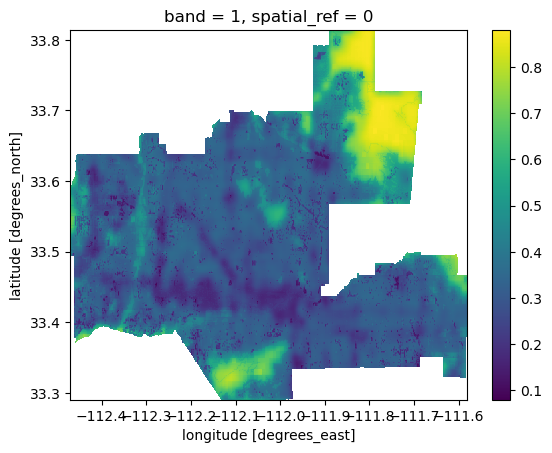

In [ ]:
bio_2017.plot()

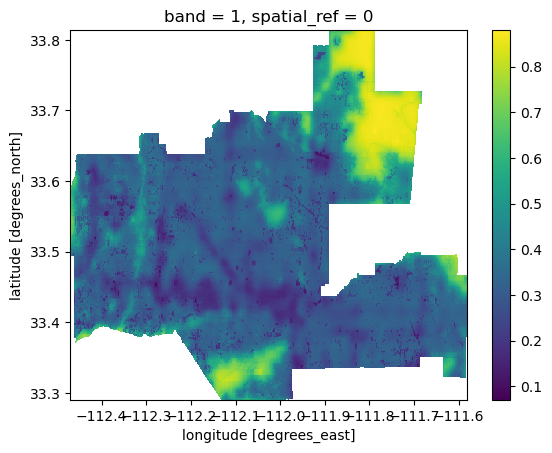

In [ ]:
bio_2020.plot()

## Determine BII Change
In this section, I will calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020. 

In [ ]:
bio_num_2017 = bio_2017 >= 0.75
perc_bio_2017 =(bio_num_2017.sum()/bio_num_2017.count()) * 100

print(f"The percentage of Phoenix subdivision with a BII of at least 0.75 in 2017 is {perc_bio_2017}")

In [ ]:
bio_num_2020 = bio_2020 >= 0.75
perc_bio_2020 =(bio_num_2020.sum()/bio_num_2020.count()) * 100

print(f"The percentage of Phoenix subdivision with a BII of at least 0.75 in 2017 is {perc_bio_2020}")

In [ ]:
bio_2017_filtered = bio_2017 >= 0.75 # produces a boolean of 0 or 1 
bio_2020_filtered = bio_2020 >= 0.75

This produces a boolean where 0 is the geometries that are not at least 0.75 BII and 1 for geometries that are at least 0.75 BII. 

View the filtered rasters.

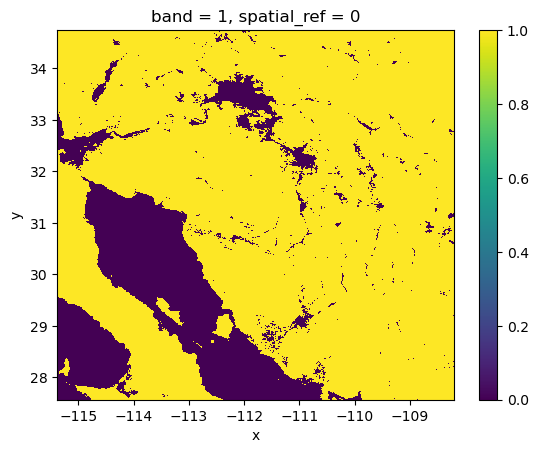

In [ ]:
bio_2017_filtered.plot()

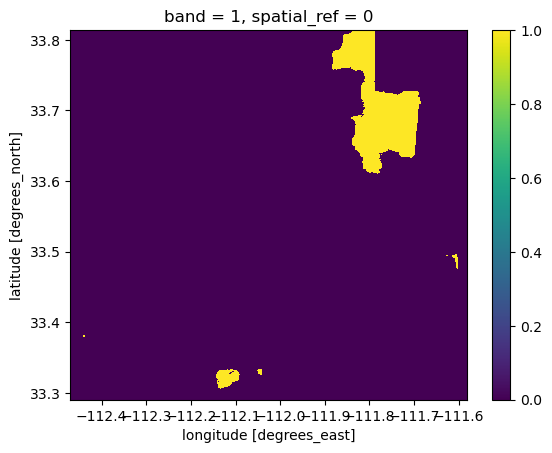

In [ ]:
bio_2020_filtered.plot()

### Change Raster Data Type
In this section I changed the raster data type to be integers in order to do raster algebrae in the next step.

In [ ]:
# Change 2017 raster to be integers
bio_2017_int = bio_2017_filtered.astype(int)
# Change 2020 raster to be integer 
bio_2020_int = bio_2020_filtered.astype(int)

In [ ]:
# subtract rasters to see difference 
bio_dif = bio_2017_int - bio_2020_int

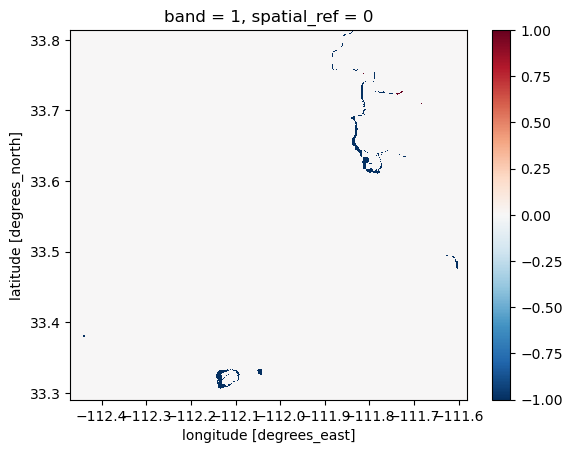

In [ ]:
bio_dif.plot() 

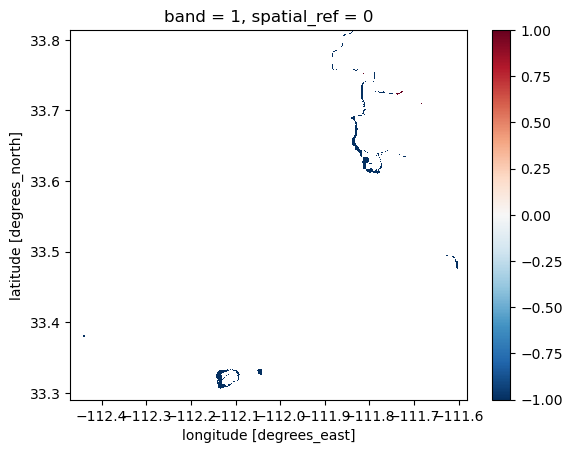

In [ ]:
loss = bio_dif.where(bio_dif != 0) 
loss.plot()

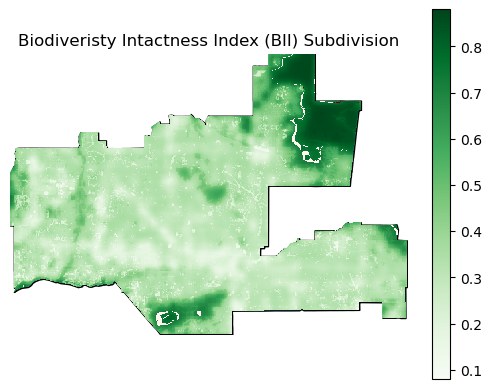

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')

# Add phoenix border
phoenix_az.plot(ax = ax, edgecolor = 'black')

# Add 2017 plot as background
bio_2017.plot(ax = ax, cmap = 'Greens') 

# Add loss 
loss.plot(ax = ax, cmap = "Reds", add_colorbar = False)

# ADD TITLE
ax.set_title("Biodiveristy Intactness Index (BII) Subdivision", fontsize=12)


#plt.tight_layout()
plt.show()

## Explanation